In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ===========================
# 📌 Preprocessing
# ===========================
def preprocess_dataset(df, label_cols, drop_cols=None):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=label_cols + drop_cols)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

# ===========================
# ⚖️ Class Weights
# ===========================
def compute_class_weights(y, num_classes, method='balanced'):
    if method == 'balanced':
        weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=y)
    elif method == 'inverse':
        class_counts = np.bincount(y)
        weights = 1. / (class_counts + 1e-5)
    else:
        weights = np.ones(num_classes)
    return torch.tensor(weights, dtype=torch.float32)

# ===========================
# 🔄 Dataloaders
# ===========================
def create_dataloaders(X, y, test_size=0.2, val_size=0.1, batch_size=64, random_state=42):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    val_relative_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_relative_size, stratify=y_train_val)

    def to_tensor_dataset(X, y):
        return TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))

    return (DataLoader(to_tensor_dataset(X_train, y_train), batch_size=batch_size, shuffle=True),
            DataLoader(to_tensor_dataset(X_val, y_val), batch_size=batch_size),
            DataLoader(to_tensor_dataset(X_test, y_test), batch_size=batch_size))

# ===========================
# 🧠 MLP Model
# ===========================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], num_classes=6,
                 dropout_rates=[0.4, 0.3, 0.2], activation='relu', use_batchnorm=True):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim, dropout in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev_dim, h_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h_dim))
            layers.append({'relu': nn.ReLU(), 'leakyrelu': nn.LeakyReLU(0.1), 'gelu': nn.GELU()}[activation])
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ===========================
# 🔥 Focal Loss (optional)
# ===========================
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=1)
        prob = torch.exp(log_prob)
        focal_weight = (1 - prob).pow(self.gamma)
        return F.nll_loss(focal_weight * log_prob, target, weight=self.weight, reduction=self.reduction)

# ===========================
# 🌡️ Temperature Scaling
# ===========================
def apply_temperature_scaling(logits, temperature=1.0):
    return logits / temperature

# ===========================
# 🎯 Threshold Tuning
# ===========================
def find_best_thresholds(probabilities, labels, num_classes):
    thresholds = np.linspace(0.1, 0.9, 9)
    best_thresholds = np.zeros(num_classes)
    for class_idx in range(num_classes):
        best_f1, best_thresh = 0, 0.5
        for thresh in thresholds:
            preds = (np.array(probabilities)[:, class_idx] > thresh).astype(int)
            true = (np.array(labels) == class_idx).astype(int)
            f1 = f1_score(true, preds)
            if f1 > best_f1:
                best_f1, best_thresh = f1, thresh
        best_thresholds[class_idx] = best_thresh
    return best_thresholds

# ===========================
# 📊 Metric Plots
# ===========================
def plot_per_class_metrics(all_labels, all_preds, label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, labels=range(len(label_names)))
    x = range(len(label_names))
    plt.figure(figsize=(12, 5))
    width = 0.25
    plt.bar([p - width for p in x], precision, width=width, label='Precision')
    plt.bar(x, recall, width=width, label='Recall')
    plt.bar([p + width for p in x], f1, width=width, label='F1-score')
    plt.xticks(ticks=x, labels=label_names, rotation=45, ha='right')
    plt.title("Per-Class Precision, Recall, and F1-score")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===========================
# 🧾 Global F1 Scores
# ===========================
def print_f1_summary(all_labels, all_preds):
    macro = f1_score(all_labels, all_preds, average='macro')
    weighted = f1_score(all_labels, all_preds, average='weighted')
    print(f"\n🔍 Macro F1 Score: {macro:.4f}")
    print(f"🔍 Weighted F1 Score: {weighted:.4f}")
    return macro, weighted


c:\Users\lamia\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# (Existing functions go here...)

# ===========================
# 🚀 Main Pipeline Runner
# ===========================
def run_pipeline(df, label_cols, drop_cols=None,
                 hidden_dims=[256, 128, 64],
                 dropout_rates=[0.4, 0.3, 0.2],
                 activation='relu',
                 use_batchnorm=True,
                 batch_size=64,
                 lr=0.001,
                 weight_decay=1e-4,
                 epochs=100,
                 use_focal_loss=False,
                 use_temperature_scaling=False,
                 optimize_thresholds=False):

    print("🔄 Running MLP pipeline...")
    X, y, scaler = preprocess_dataset(df, label_cols=label_cols, drop_cols=drop_cols)
    train_loader, val_loader, test_loader = create_dataloaders(X, y, batch_size=batch_size)

    # Extract class weights
    all_train_labels = []
    for _, labels in train_loader:
        all_train_labels.extend(labels.numpy())
    class_weights = compute_class_weights(np.array(all_train_labels), num_classes=len(label_cols), method='balanced')

    # Initialize model
    model = CowHealthMLP(input_dim=X.shape[1], hidden_dims=hidden_dims, num_classes=len(label_cols),
                         dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm)

    # Loss and optimizer
    criterion = FocalLoss(weight=class_weights) if use_focal_loss else nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    best_val_loss = float('inf')
    best_model = None
    train_loss_history = []
    val_loss_history = []
    val_f1_history = []
    patience = 30
    min_delta = 0.001
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        val_f1_history.append(val_f1)
        scheduler.step(val_loss)

        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_model:
        model.load_state_dict(best_model)

    # Plot loss/F1
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.legend(); plt.grid(); plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(val_f1_history, label='Val F1', color='green')
    plt.legend(); plt.grid(); plt.title('F1')
    plt.tight_layout(); plt.show()

    # Evaluate on test
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            if use_temperature_scaling:
                outputs = apply_temperature_scaling(outputs, temperature=1.5)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)

    if optimize_thresholds:
        thresholds = find_best_thresholds(all_probs, all_labels, len(label_cols))
        print("\n🎯 Optimal per-class thresholds:", thresholds)
    
    return model, scaler, {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'confusion_matrix': confusion_matrix(all_labels, all_preds),
        'thresholds': thresholds if optimize_thresholds else None
    }


🔄 Running MLP pipeline...


Training:  94%|█████████▍| 189/200 [40:56<02:22, 13.00s/it] 


Early stopping at epoch 190


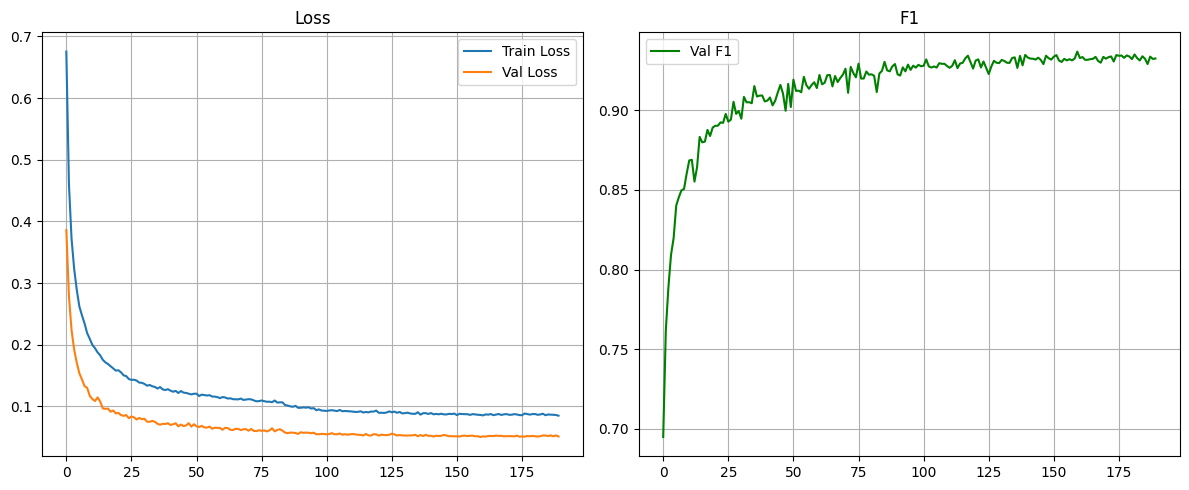


📊 Classification Report:
               precision    recall  f1-score   support

      oestrus       0.78      0.97      0.87      3599
      calving       0.99      1.00      0.99      3731
     lameness       0.98      1.00      0.99      3729
     mastitis       0.98      1.00      0.99      3727
other_disease       0.96      1.00      0.98      3713
           OK       0.96      0.59      0.73      3208

     accuracy                           0.93     21707
    macro avg       0.94      0.93      0.93     21707
 weighted avg       0.94      0.93      0.93     21707



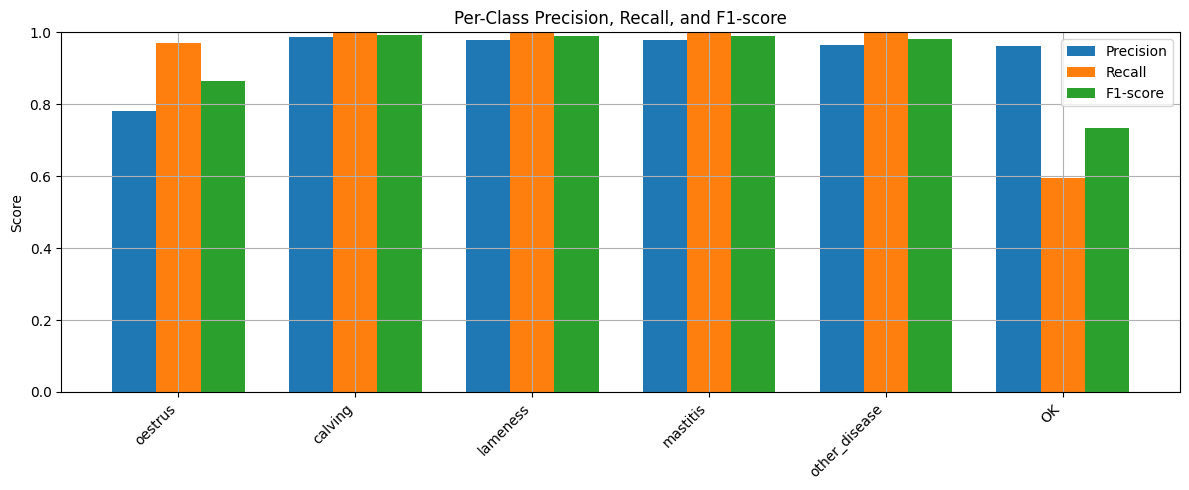


🔍 Macro F1 Score: 0.9254
🔍 Weighted F1 Score: 0.9303

🎯 Optimal per-class thresholds: [0.5 0.6 0.6 0.6 0.5 0.4]
Pipeline completed. Results: {'predictions': [2, 3, 1, 2, 4, 0, 2, 4, 4, 1, 2, 0, 0, 2, 0, 3, 4, 3, 1, 0, 4, 1, 0, 3, 0, 3, 3, 5, 1, 3, 4, 0, 2, 1, 5, 4, 5, 1, 2, 1, 1, 0, 4, 4, 5, 5, 1, 3, 0, 1, 1, 2, 5, 1, 0, 1, 2, 2, 0, 4, 4, 1, 4, 3, 4, 3, 4, 0, 2, 2, 0, 3, 2, 2, 2, 2, 0, 3, 2, 3, 2, 5, 2, 3, 1, 5, 3, 0, 4, 1, 5, 3, 1, 4, 4, 3, 3, 1, 0, 1, 0, 0, 2, 1, 4, 0, 1, 0, 4, 2, 4, 1, 2, 0, 1, 3, 3, 3, 4, 1, 2, 0, 1, 2, 5, 2, 4, 4, 2, 3, 2, 3, 1, 3, 2, 1, 5, 1, 1, 4, 1, 0, 3, 3, 1, 2, 3, 2, 4, 4, 4, 2, 0, 1, 5, 3, 4, 1, 1, 4, 0, 4, 0, 5, 2, 4, 5, 4, 2, 2, 3, 2, 5, 2, 0, 1, 3, 3, 1, 2, 1, 0, 0, 0, 0, 5, 1, 2, 3, 4, 4, 0, 1, 0, 2, 5, 1, 0, 3, 4, 0, 1, 0, 1, 2, 0, 0, 1, 5, 4, 3, 5, 2, 3, 1, 3, 1, 5, 3, 0, 1, 0, 2, 1, 0, 2, 4, 5, 5, 1, 5, 4, 0, 1, 2, 1, 2, 2, 1, 2, 0, 2, 4, 2, 0, 5, 0, 0, 3, 3, 4, 1, 2, 5, 3, 0, 4, 4, 0, 5, 0, 1, 1, 4, 5, 0, 2, 0, 1, 0, 2, 4, 3, 0, 2, 0, 5, 1, 3, 4, 3

In [7]:
import pandas as pd
from pathlib import Path

# Load your dataset
df = pd.read_csv(Path("C:/Users/lamia/Downloads/augmented_dataset1_trainval.csv"))

# Run the pipeline
model, scaler, results = run_pipeline(
    df=df,
    label_cols=['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK'],
    drop_cols=['cow', 'duration_hours'],
    hidden_dims=[512, 256, 128],
    dropout_rates=[0.5, 0.4, 0.3],
    activation='leakyrelu',
    use_batchnorm=True,
    batch_size=128,
    lr=0.0005,
    weight_decay=1e-4,
    epochs=200,
    use_focal_loss=True,
    use_temperature_scaling=True,
    optimize_thresholds=True
)

# Optional: Access results
print("Pipeline completed. Results:", results)

**TESTTT**

🔄 Running MLP pipeline...


Training:  98%|█████████▊| 197/200 [01:42<00:01,  1.92it/s]


Early stopping at epoch 198


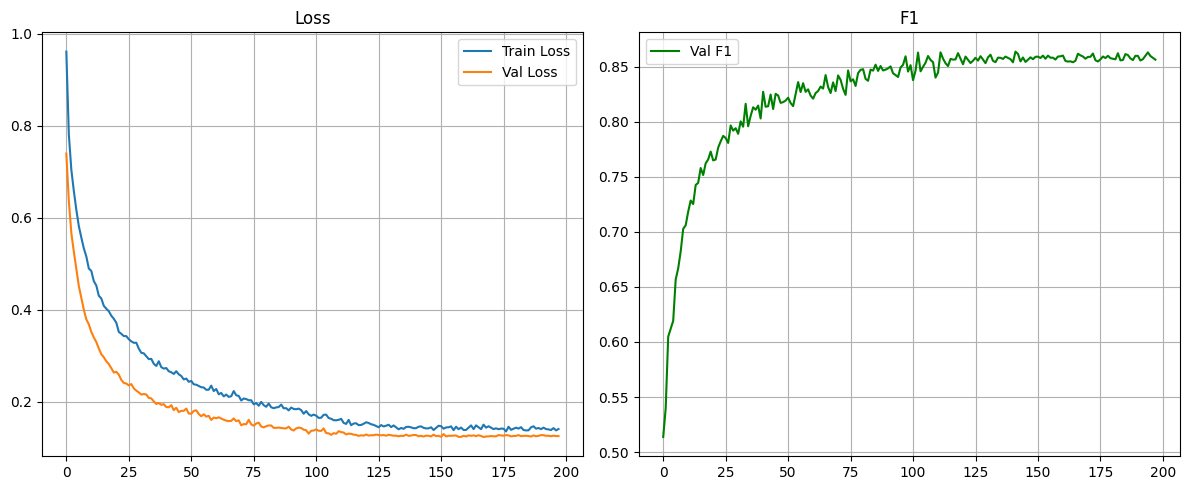


📊 Classification Report:
               precision    recall  f1-score   support

      oestrus       0.75      0.84      0.79       400
      calving       0.97      1.00      0.98       414
     lameness       0.93      1.00      0.97       414
     mastitis       0.93      0.99      0.96       414
other_disease       0.91      0.98      0.94       413
           OK       0.79      0.44      0.57       357

     accuracy                           0.89      2412
    macro avg       0.88      0.88      0.87      2412
 weighted avg       0.88      0.89      0.88      2412



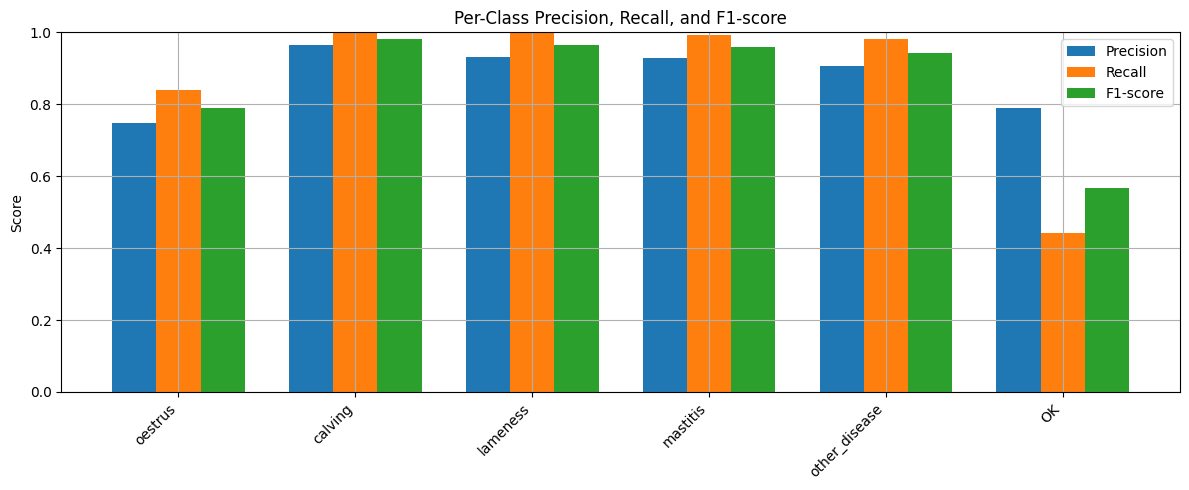


🔍 Macro F1 Score: 0.8679
🔍 Weighted F1 Score: 0.8754

🎯 Optimal per-class thresholds: [0.4 0.5 0.5 0.5 0.4 0.3]
Pipeline completed. Results: {'predictions': [2, 3, 4, 5, 0, 0, 1, 2, 4, 4, 4, 2, 2, 0, 4, 4, 2, 1, 0, 4, 5, 2, 5, 3, 0, 1, 0, 4, 0, 3, 4, 1, 5, 4, 2, 2, 1, 3, 1, 5, 3, 1, 5, 3, 1, 4, 4, 1, 0, 0, 3, 4, 3, 4, 2, 1, 4, 3, 3, 4, 3, 1, 2, 2, 3, 2, 4, 1, 3, 0, 3, 2, 3, 1, 2, 1, 2, 0, 0, 0, 0, 3, 1, 3, 4, 1, 2, 4, 3, 4, 0, 4, 0, 1, 3, 4, 1, 1, 3, 2, 2, 1, 0, 3, 3, 4, 3, 1, 3, 2, 0, 2, 0, 5, 3, 5, 4, 0, 5, 2, 2, 1, 3, 4, 0, 1, 1, 4, 1, 0, 5, 0, 1, 4, 3, 0, 3, 1, 5, 3, 2, 0, 3, 0, 0, 0, 3, 5, 0, 2, 4, 1, 3, 4, 2, 0, 3, 2, 2, 1, 3, 4, 0, 0, 3, 4, 2, 3, 4, 1, 0, 4, 4, 2, 2, 4, 3, 2, 2, 4, 5, 4, 2, 0, 2, 1, 2, 1, 5, 2, 5, 4, 4, 0, 3, 1, 0, 0, 1, 1, 4, 1, 0, 2, 2, 3, 4, 0, 4, 0, 1, 1, 5, 4, 4, 4, 5, 0, 4, 4, 1, 2, 0, 2, 0, 1, 1, 0, 3, 3, 2, 4, 0, 4, 4, 1, 4, 4, 0, 3, 0, 5, 3, 2, 4, 5, 4, 2, 2, 3, 0, 2, 3, 1, 0, 2, 4, 2, 0, 4, 0, 1, 5, 1, 3, 4, 5, 1, 2, 5, 4, 0, 0, 0, 0, 4, 2, 4, 3, 0, 2

In [8]:
import pandas as pd
from pathlib import Path

# Load your dataset
df = pd.read_csv(Path("C:/Users/lamia/Downloads/augmented_dataset1_holdout.csv"))

# Run the pipeline
model, scaler, results = run_pipeline(
    df=df,
    label_cols=['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK'],
    drop_cols=['cow', 'duration_hours'],
    hidden_dims=[512, 256, 128],
    dropout_rates=[0.5, 0.4, 0.3],
    activation='leakyrelu',
    use_batchnorm=True,
    batch_size=128,
    lr=0.0005,
    weight_decay=1e-4,
    epochs=200,
    use_focal_loss=True,
    use_temperature_scaling=True,
    optimize_thresholds=True
)

# Optional: Access results
print("Pipeline completed. Results:", results)

🔄 Running MLP pipeline...


Training: 100%|██████████| 150/150 [06:05<00:00,  2.44s/it]


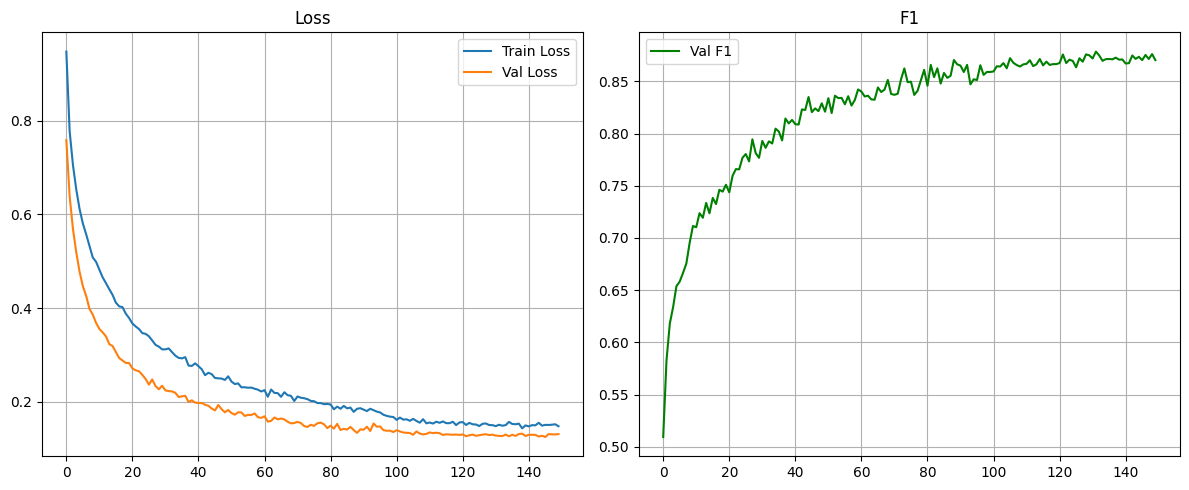


📊 Classification Report:
               precision    recall  f1-score   support

      oestrus       0.73      0.81      0.77       400
      calving       0.97      1.00      0.98       414
     lameness       0.91      1.00      0.95       414
     mastitis       0.92      0.99      0.95       414
other_disease       0.90      0.98      0.93       413
           OK       0.80      0.42      0.55       357

     accuracy                           0.88      2412
    macro avg       0.87      0.87      0.86      2412
 weighted avg       0.87      0.88      0.87      2412



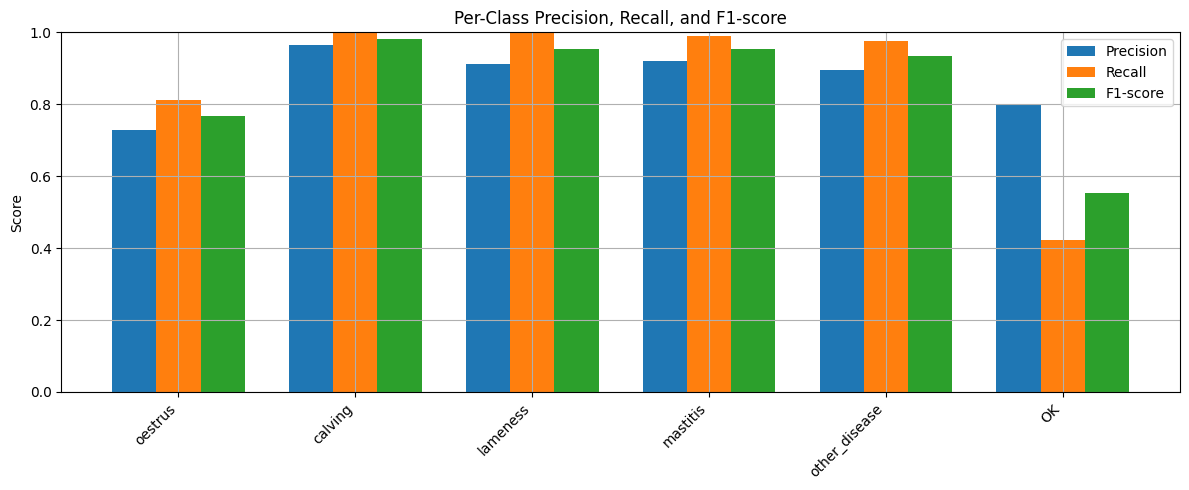


🔍 Macro F1 Score: 0.8575
🔍 Weighted F1 Score: 0.8652

🎯 Optimal per-class thresholds: [0.4 0.5 0.5 0.6 0.4 0.3]
Pipeline completed. Results: {'predictions': [2, 3, 4, 5, 0, 0, 1, 2, 4, 4, 4, 2, 2, 0, 4, 4, 2, 1, 0, 4, 5, 2, 5, 3, 0, 1, 0, 4, 0, 3, 4, 1, 1, 4, 2, 2, 1, 3, 1, 3, 3, 1, 5, 3, 1, 4, 4, 1, 0, 0, 3, 4, 3, 4, 2, 1, 4, 3, 3, 4, 3, 1, 2, 2, 3, 2, 4, 1, 3, 0, 3, 2, 3, 1, 2, 1, 2, 0, 0, 0, 0, 3, 1, 3, 4, 1, 2, 4, 3, 4, 0, 4, 0, 1, 3, 4, 1, 1, 3, 2, 2, 1, 0, 3, 2, 4, 3, 1, 3, 2, 0, 2, 5, 5, 3, 5, 4, 0, 5, 2, 2, 1, 3, 4, 0, 1, 1, 4, 1, 0, 0, 0, 1, 4, 3, 0, 3, 1, 5, 3, 2, 0, 3, 0, 0, 0, 3, 5, 0, 2, 4, 1, 3, 4, 2, 0, 3, 2, 2, 1, 3, 4, 0, 0, 3, 4, 2, 3, 4, 1, 0, 4, 4, 2, 2, 4, 3, 2, 2, 4, 5, 4, 2, 0, 2, 1, 2, 1, 0, 2, 5, 4, 4, 0, 3, 1, 0, 0, 1, 1, 4, 1, 0, 2, 2, 3, 4, 0, 4, 0, 1, 1, 5, 4, 4, 4, 5, 0, 4, 4, 1, 2, 5, 2, 0, 1, 1, 4, 3, 3, 2, 4, 0, 4, 4, 1, 4, 4, 0, 3, 4, 5, 3, 2, 4, 0, 4, 2, 2, 3, 0, 2, 3, 1, 0, 2, 4, 2, 0, 4, 4, 1, 0, 1, 3, 4, 5, 1, 2, 4, 4, 5, 0, 0, 5, 4, 2, 5, 3, 0, 2

In [4]:
import pandas as pd
from pathlib import Path

# Load your dataset
df = pd.read_csv(Path("C:/Users/lamia/Downloads/augmented_dataset1_holdout.csv"))

# Run the pipeline
model, scaler, results = run_pipeline(
    df=df,
    label_cols=['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK'],
    drop_cols=['cow', 'duration_hours'],
    hidden_dims=[512, 256, 128],
    dropout_rates=[0.5, 0.4, 0.3],
    activation='leakyrelu',
    use_batchnorm=True,
    batch_size=128,
    lr=0.0005,
    weight_decay=1e-4,
    epochs=150,
    use_focal_loss=True,
    use_temperature_scaling=True,
    optimize_thresholds=True
)

# Optional: Access results
print("Pipeline completed. Results:", results)

Training:  59%|█████▉    | 118/200 [4:14:28<2:56:50, 129.40s/it] 


Early stopping at epoch 119


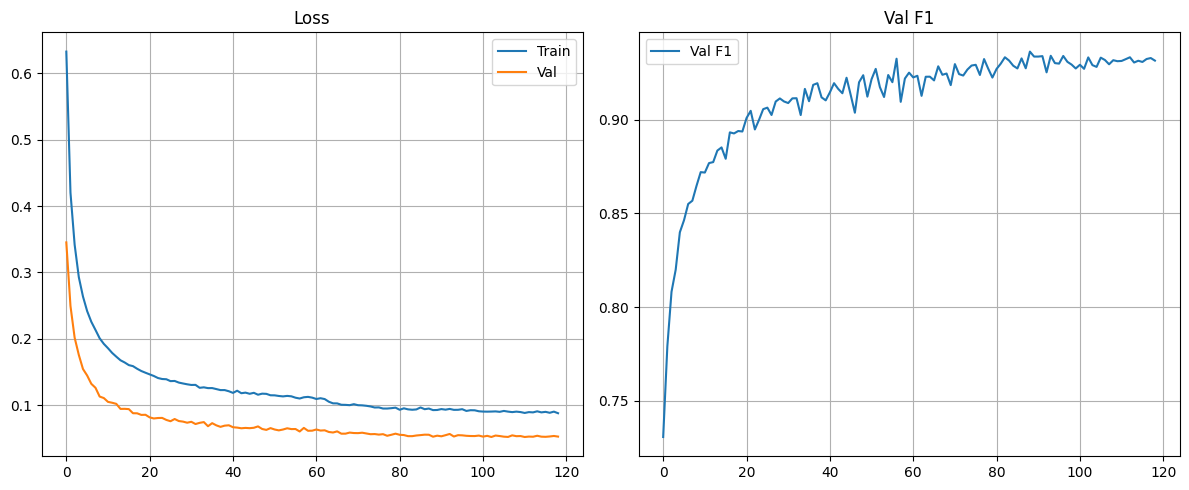

✓ Learned temperature on validation: T = 0.591

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.78      0.97      0.86      2000
      calving       0.99      1.00      1.00      2072
     lameness       0.97      1.00      0.99      2072
     mastitis       0.98      1.00      0.99      2071
other_disease       0.96      1.00      0.98      2063
           OK       0.96      0.59      0.73      1782

     accuracy                           0.93     12060
    macro avg       0.94      0.93      0.92     12060
 weighted avg       0.94      0.93      0.93     12060



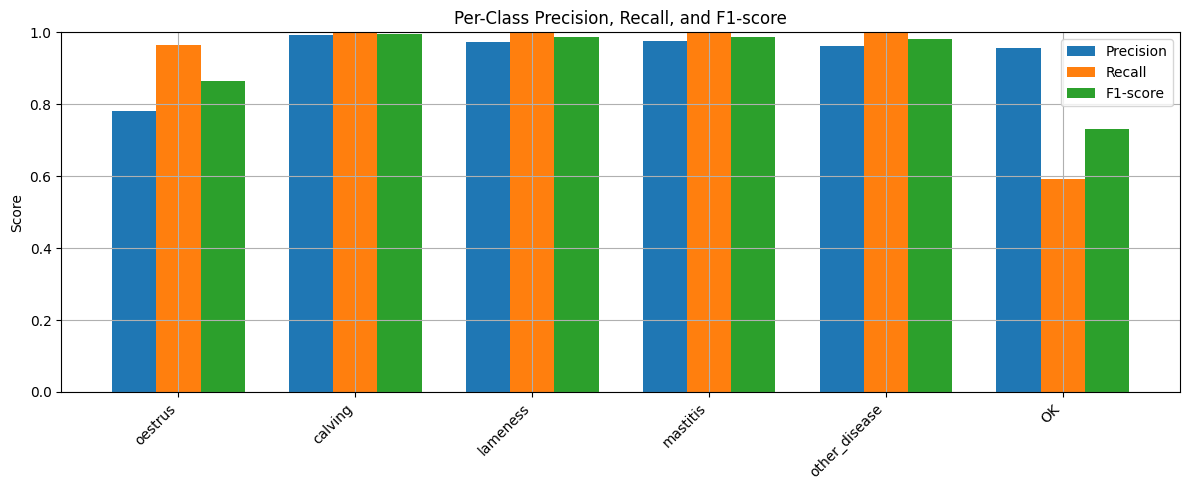


🔍 Macro F1 Score: 0.9246
🔍 Weighted F1 Score: 0.9295


In [5]:
import math, random, os, pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# ---------- Repro ----------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ---------- Preprocess ----------
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.1, random_state=42):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    X = df.drop(columns=(drop_cols or []) + label_cols)

    # stratified split train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X.values, y, test_size=val_size, random_state=random_state, stratify=y
    )
    # fit scaler on TRAIN ONLY
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler, X.columns.tolist()

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    def td(x, y): return TensorDataset(torch.tensor(x, dtype=torch.float32),
                                       torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(td(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(td(X_val,   y_val),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# ---------- Class weights from TRAIN ONLY ----------
def class_weights_from_train(y_train, n_classes):
    from sklearn.utils.class_weight import compute_class_weight
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

# ---------- Temperature fitting on VAL ----------
class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits):
        T = torch.exp(self.logT)
        return logits / T
    @property
    def T(self): return torch.exp(self.logT).item()

def learn_temperature(model, val_loader, init_T=1.0, max_iter=200, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)

    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, dim=0)
        labels = torch.cat(labels_list, dim=0)

    def closure():
        opt.zero_grad()
        scaled = temp(logits)
        loss = loss_fn(scaled, labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ---------- Train loop (early stop on VAL loss) ----------
def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=[512,256,128], dropout_rates=[0.5,0.4,0.3],
    activation='leakyrelu', use_batchnorm=True,
    batch_size=128, lr=5e-4, weight_decay=1e-4,
    epochs=200, patience=30, min_delta=1e-3,
    use_focal_loss=True, learn_temp=True
):
    set_seed(42)

    X_tr, y_tr, X_val, y_val, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=0.15, random_state=42
    )
    n_classes = len(label_cols)

    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    best_val, best_state = float('inf'), None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        # train
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward(); optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        # validate
        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='weighted')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)

        if vloss < best_val - min_delta:
            best_val, best_state = vloss, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1')
    plt.title('Val F1'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    # learn temperature on VAL (optional)
    T = 1.0
    if learn_temp:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, scaler, T
def transform_with_scaler(df, label_cols, drop_cols, scaler):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    X = df.drop(columns=(drop_cols or []) + label_cols).values
    X = scaler.transform(X)  # NOTE: using the same scaler
    return X, y

def evaluate_on_holdout(model, scaler, df_holdout, label_cols, drop_cols=None, temperature=1.0, batch_size=128):
    model.eval()
    X_test, y_test = transform_with_scaler(df_holdout, label_cols, drop_cols, scaler)
    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            logits = logits / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }
from pathlib import Path
label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
drop_cols  = ['cow','duration_hours']  # adjust if needed

# 1) Train once on train+val file
df_trainval = pd.read_csv(Path("C:/Users/lamia/Downloads/augmented_dataset1_trainval.csv"))
model, scaler, T = train_on_trainval(
    df_trainval,
    label_cols=label_cols,
    drop_cols=drop_cols,
    hidden_dims=[512,256,128],
    dropout_rates=[0.5,0.4,0.3],
    activation='leakyrelu',
    use_batchnorm=True,
    batch_size=128,
    lr=5e-4,
    weight_decay=1e-4,
    epochs=200,
    use_focal_loss=True,
    learn_temp=True    # temperature learned on validation
)

# 2) Evaluate on true holdout without retraining
df_holdout = pd.read_csv(Path("C:/Users/lamia/Downloads/augmented_dataset1_holdout.csv"))
holdout_results = evaluate_on_holdout(
    model, scaler, df_holdout,
    label_cols=label_cols, drop_cols=drop_cols, temperature=T, batch_size=128
)
